# Problema de Négocio 

**A Empresa Cardio Catch Diseases ( CCD )**

A Cadio Catch Diseases é uma empresa especializada em detecção de doenças cardíacas em estágios iniciais. O seu modelo de negócio é do tipo Serviço, ou seja, a empresa ofereço o diagnóstico precoce de uma doença cardiovascular por um certo preço.

Atualmente, o diagnóstico de uma doença cardiovascular é feita manualmente por uma equipe de especialistas. A precisão atual do diagnóstico varia entre 55% e 65%, devido a complexidade do diagnóstico e também da fadiga da equipe que se revezam em turnos para minimizar os riscos. O custo de cada diagnóstico, incluindo os aparelhos e a folha de pagamento dos analistas, gira em torno de R$ 1.000,00.

O preço do diagnóstico, pago pelo cliente, varia de acordo com a precisão conseguida pelo time de especialistas, o cliente paga 500 Reais a cada 5% de acurácia acima de 50%. Por exemplo, para uma precisão de 55%, o diagnóstico custa 500 reais para o cliente, para uma precisão de 60%, o valor é de R$ 1000,00 e assim por diante. Se a precisão do diagnóstico for 50%. o cliente não paga por ele.

Observe que a variação da precisão dada pelo time de especialistas, faz com que a empresa tenha ora uma operação com lucro, receita maior que o custo, ora uma operação com prejuízo, receita menor que o custo. Essa instabilidade do diagnóstico faz com que a empresa tenha um Cashflow imprevisível.

O seu objetivo como o Cientista de Dados contratado pela Cardio Catch Diseases é criar uma ferramenta que aumente a precisão do diagnóstico e que essa precisão seja estável para todos os diagnósticos.

Portanto o seu trabalho como Data Scientist é criar um ferramenta de classificação de doentes, como uma precisão estável. Junto com a ferramenta, você precisa enviar um relatório para o CEO da Cardio Catch Diseases, reportando os resultados e respondendo às seguintes perguntas: ( Ele provavelmente irá fazer essas pergunta no dia da sua apresentação. )

- Qual a Acurácia e a Precisão da ferramenta?
- Quanto lucro a Cardio Catch Diseases passará a ter com a nova ferramenta?
- Qual a Confiabilidade do resultado dados pela nova ferramenta?

# 0.0 Importações 

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt
import warnings
warnings.filterwarnings('ignore')

from sklearn.svm             import SVC
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV, KFold
from sklearn.metrics         import accuracy_score, confusion_matrix, classification_report, roc_auc_score
from IPython.display         import Image
from sklearn.ensemble        import RandomForestClassifier
from sklearn.preprocessing   import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble        import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors       import KNeighborsClassifier
from sklearn.linear_model    import LogisticRegression
from sklearn.dummy           import DummyClassifier
from sklearn.tree            import DecisionTreeClassifier
from sklearn.model_selection   import train_test_split, StratifiedKFold, cross_validate

## 0.1 Funções

In [2]:
def obesity(coluna):
    if coluna <= 18.5:
        return 1
    elif coluna >18.5 and coluna <=24.9:
        return 2
    elif coluna >25 and coluna <=29.9:
        return 3
    elif coluna >30 and coluna <=34.9:
        return 4
    else:
        return 5

In [3]:
# Função para calculo de métricas dos Modelos.
def ml_error(model_name,modelo):
    scores = cross_validate(modelo, X_train, y_train, cv=kfold ,scoring=('precision',
                                                                         'accuracy',
                                                                         'recall',
                                                                        'roc_auc',
                                                                        'average_precision'),return_train_score=False)
    return pd.DataFrame({'Model_Name':model_name,
                        'Acuracia':(scores['test_accuracy'].mean()),
                        'Precision': (scores['test_precision'].mean()),
                        'Recall': (scores['test_recall'].mean()),
                        'ROC_AUC':(scores['test_roc_auc'].mean()),
                        'Precision-Recall':(scores['test_average_precision'].mean())},index=[0])  
                                                                                      

# 1.0 - Análise Descritiva

In [4]:
df = pd.read_csv('cardio_train.csv', sep = ";")

In [5]:
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


In [6]:
df.shape

(70000, 13)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,70000.0,49972.419900,28851.302323,0.0,25006.75,50001.5,74889.25,99999.0
age,70000.0,19468.865814,2467.251667,10798.0,17664.00,19703.0,21327.00,23713.0
gender,70000.0,1.349571,0.476838,1.0,1.00,1.0,2.00,2.0
height,70000.0,164.359229,8.210126,55.0,159.00,165.0,170.00,250.0
weight,70000.0,74.205690,14.395757,10.0,65.00,72.0,82.00,200.0
ap_hi,70000.0,128.817286,154.011419,-150.0,120.00,120.0,140.00,16020.0
ap_lo,70000.0,96.630414,188.472530,-70.0,80.00,80.0,90.00,11000.0
cholesterol,70000.0,1.366871,0.680250,1.0,1.00,1.0,2.00,3.0
gluc,70000.0,1.226457,0.572270,1.0,1.00,1.0,1.00,3.0
smoke,70000.0,0.088129,0.283484,0.0,0.00,0.0,0.00,1.0


## 1.2 Verificando valores faltantes

In [9]:
df.isnull().sum()

id             0
age            0
gender         0
height         0
weight         0
ap_hi          0
ap_lo          0
cholesterol    0
gluc           0
smoke          0
alco           0
active         0
cardio         0
dtype: int64

# 2.0 Feature Engineering

In [10]:
# conversão de dias da idade para anos
df['age'] = df['age'].apply( lambda x: round(x/365))

# soma dos fatores de risco
df['sum_risk_factors'] = df['cholesterol']+df['gluc']+df['smoke']+df['alco']

# total de fatores de risco menos um peso para quem faz atividade física
df['activity_weight'] = df['sum_risk_factors'] - df['active']

# Calculando IMC
df['imc'] = df['weight'] / ((df['height']/100) * (df['height']/100))

#Calculando grau de obesidade
df['obesity'] = df['imc'].apply(obesity)

#Pressão alta dividida por pressão baixa
df['hi_per_low'] = df['ap_hi'] / df['ap_lo']

# 2.0 Mapa Mental de hipoteses 

## 2.1 Mapa mental

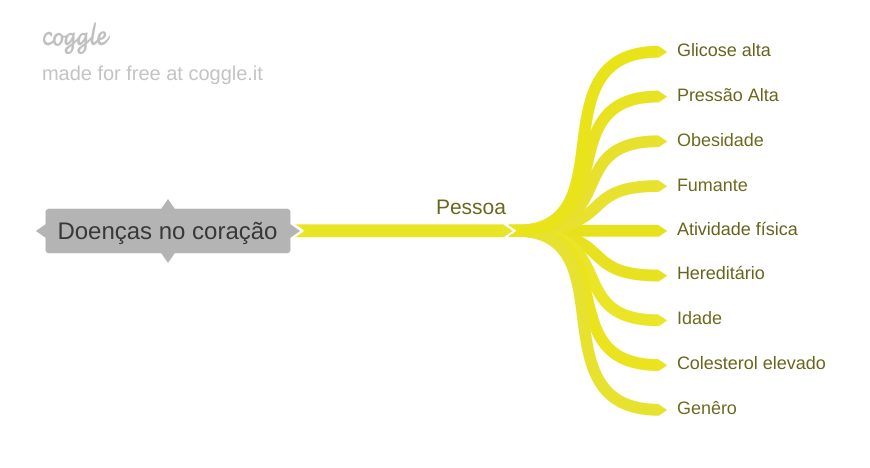

In [11]:
Image ('img\Doenas_no_corao.png')

## Hipoteses

**H1** - Pessoas com mais de 60 anos tem duas vezes mais chances de ter problema no coração do que uma pessoa com menos de 60 anos.

**H2** - Em média, um gênero tem mais chances de ter problema no coração do que o outro.

**H3** - Pressão alta acima de 140 aumenta duas vezes o risco de ter problema no coração.

**H4** - Pressão baixa acima de 80 aumenta duas vezes o risco de ter problema no coração.

**H5** - Colesterol alto é um fator importante para problemas no coração.

**H6** - Pessoas que fumam tem 2 vezes mais chances de ter um problema no coração.

**H7** - O Alcool não é um fator importante para quem doenças no coração.

**H8** - Pessoas ativas tem menos chances de desenvolver um  problema no coração.

**H9** - Pessoas que acumulam Colesterol e/ou Glicose e/ou fumam e/ou bebem tem o dobro de pessoas que não tem essas características.

**H10** - Pessoas com grau de obesidade acima de 2 tem duas vezes mais chances de ter problema no coração.

# 3.0 Análise exploratória

##  3.1 - Análise Univariada

### 3.1.0 -  Variável Resposta - Cardio

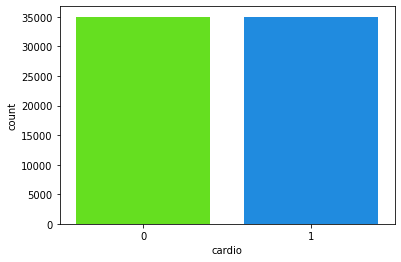

In [12]:
# Variável resposta
sns.countplot(x='cardio', data=df, palette='gist_rainbow');

### 3.1.1 - Variável  Age - Idade

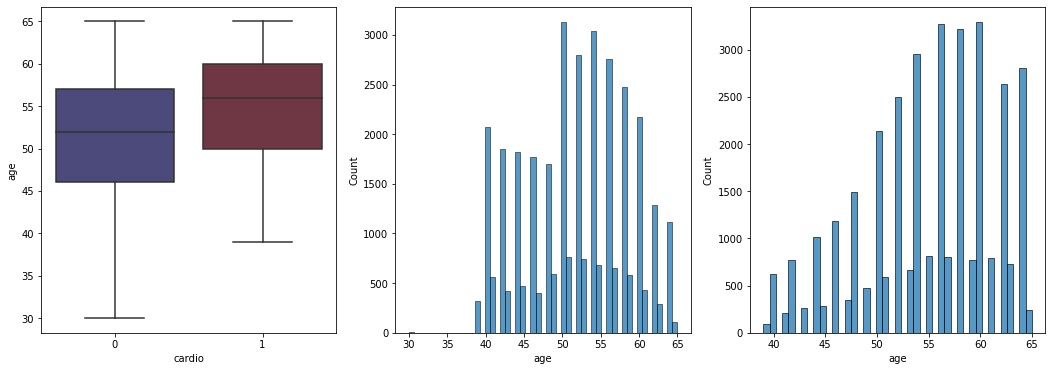

In [13]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
sns.boxplot(x='cardio', y='age', data=df, palette='icefire');

plt.subplot(1,3,2)
aux00 = df.loc[df['cardio'] == 0, 'age']
sns.histplot(aux00, palette='icefire')

plt.subplot(1,3,3)
aux00 = df.loc[df['cardio'] == 1, 'age']
sns.histplot(aux00, palette='icefire');

**Os pacientes que possuem doenças cardíacas possuem uma média de idade maior do que os pacientes que não possuem.**

### 3.1.2 - Variável Gender - Gênero

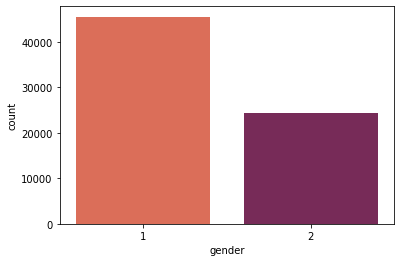

In [14]:
sns.countplot(x='gender', data=df, palette='rocket_r');

### 3.1.3 - Variável Weight - Peso

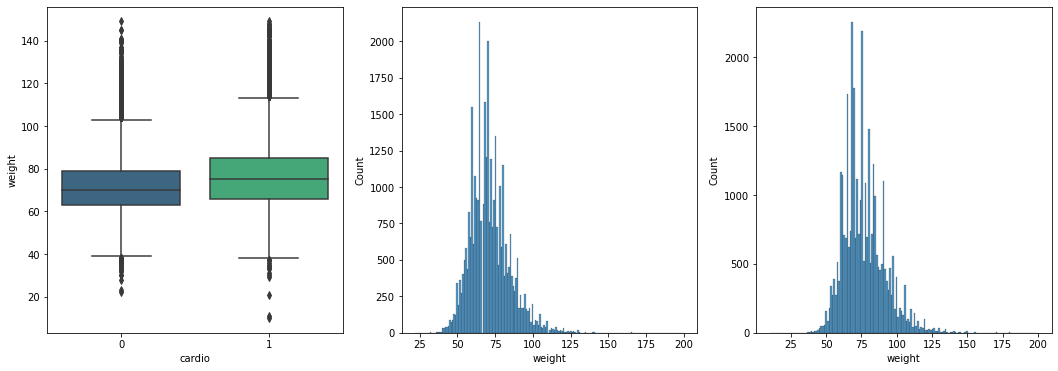

In [15]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
aux = df[df['weight'] < 150]
sns.boxplot(x='cardio', y='weight', data=aux, palette='viridis');

plt.subplot(1,3,2)
aux00 = df.loc[df['cardio'] == 0, 'weight']
sns.histplot(aux00)

plt.subplot(1,3,3)
aux00 = df.loc[df['cardio'] == 1, 'weight']
sns.histplot(aux00);

### 3.1.4 - Variável Height - Altura

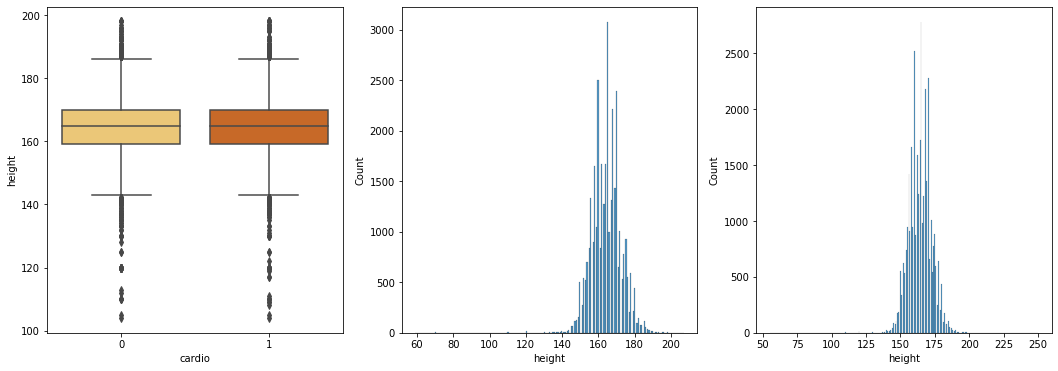

In [16]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
aux = df[(df['height'] >100) & (df['height'] < 200)]
sns.boxplot(x='cardio', y='height', data=aux, palette='YlOrBr');

plt.subplot(1,3,2)
aux00 = df.loc[df['cardio'] == 0, 'height']
sns.histplot(aux00)

plt.subplot(1,3,3)
aux00 = df.loc[df['cardio'] == 1, 'height']
sns.histplot(aux00);

### 3.1.5 - Variáveis ap_hi, ap_lo e age - Pressão alta, Pressão Baixa e Idade

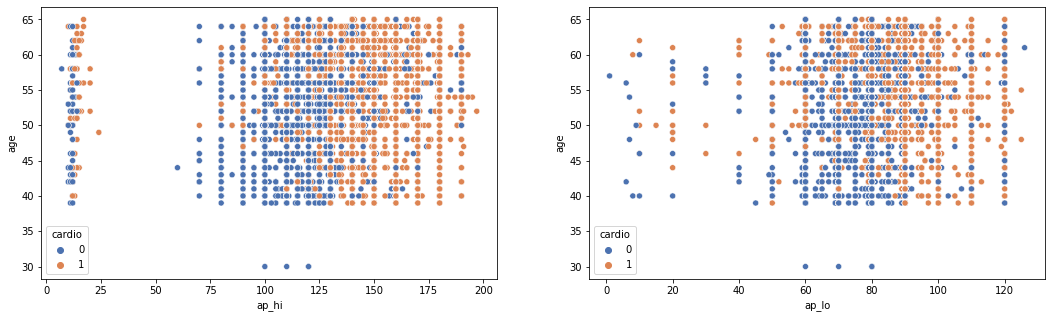

In [17]:
df1 = df[(df['ap_hi']>0) & (df['ap_hi']<200) & (df['ap_lo']>0) & (df['ap_lo']<130)]
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
sns.scatterplot(x='ap_hi', y='age', hue='cardio', data=df1, palette='deep');

plt.subplot(1,2,2)
sns.scatterplot(x='ap_lo', y='age', hue='cardio', data=df1, palette='deep');

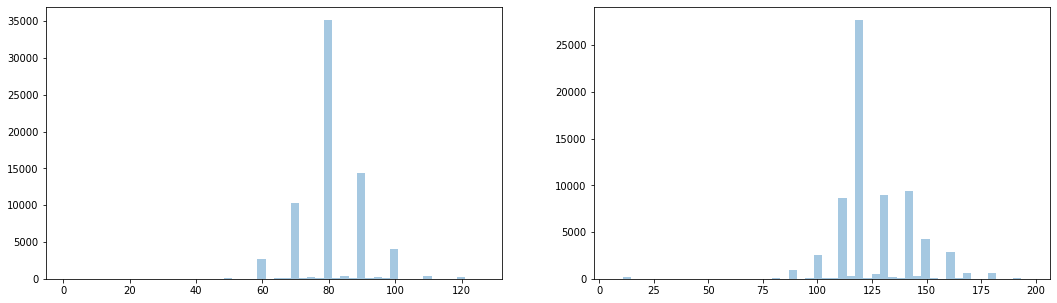

In [18]:
plt.figure(figsize=(18,5))
plt.subplot(1,2,1)
sns.distplot(x=df1['ap_lo'], kde=False);

plt.subplot(1,2,2)
sns.distplot(x=df1['ap_hi'], kde=False);

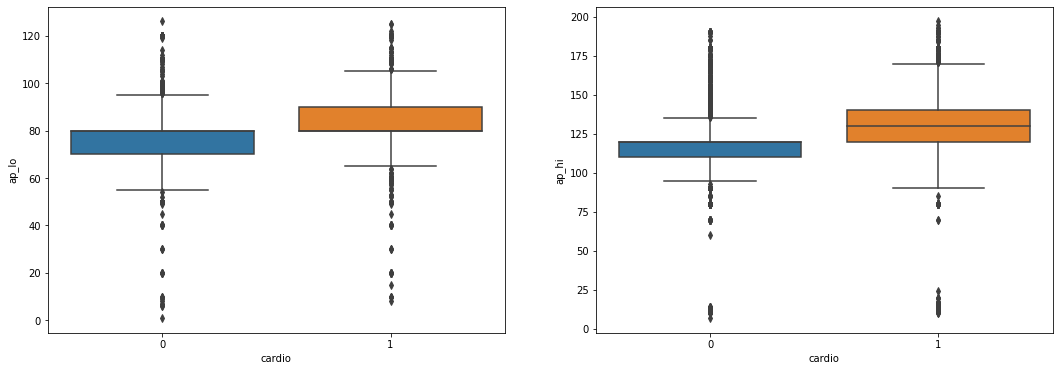

In [19]:
plt.figure(figsize=(18,6))
plt.subplot(1,2,1)
sns.boxplot(x='cardio', y='ap_lo', data=df1);

plt.subplot(1,2,2)
sns.boxplot(x='cardio', y='ap_hi', data=df1);

In [20]:
# No segundo ciclo, analisar esses números muito pequenos de ap_hi e ap_lo

### 3.1.6 - Variável Cholesterol - Colesterol

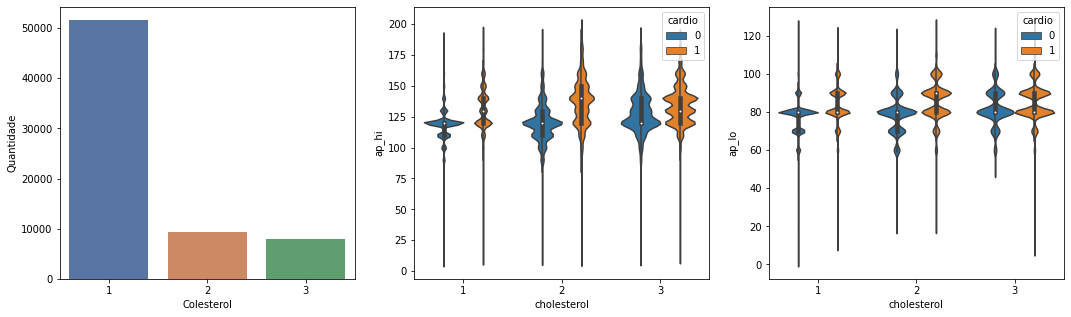

In [21]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
sns.countplot(x = 'cholesterol', data=df1,palette='deep')
plt.xlabel('Colesterol')
plt.ylabel('Quantidade');

plt.subplot(1,3,2)
sns.violinplot(x='cholesterol', y='ap_hi', hue='cardio', data=df1);
               
plt.subplot(1,3,3)
sns.violinplot(x='cholesterol', y='ap_lo', hue='cardio', data=df1);

In [22]:
# Poucas pessoas com Colesterol normal e pressão alta tem problemas no coração.
# Pessoas que possuem colesterol fora do normal, a pressão alta é um fator de risco.
# Pessoas que possuem colesterol muito fora do normal, a pressão alta é um fator de risco
# Pressão alta parece estar fortemente ligada aos fatores de risco.

### 3.1.7 - Variável Gluc - Glicose

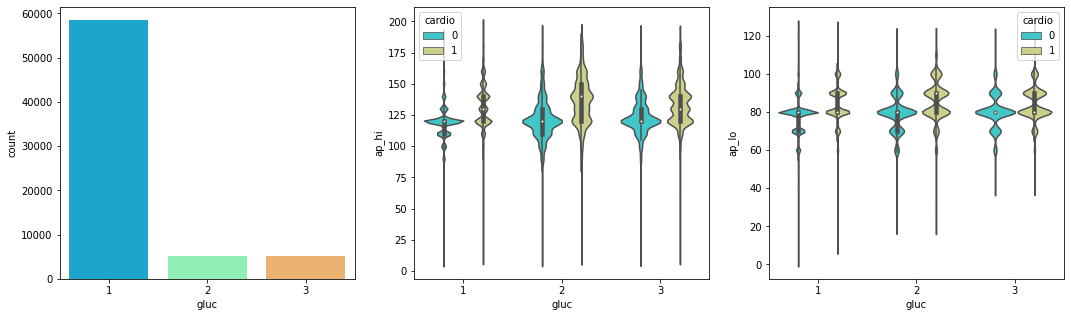

In [23]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
sns.countplot(x='gluc', data=df1, palette='rainbow');

plt.subplot(1,3,2)
sns.violinplot(x='gluc', y='ap_hi', hue='cardio', data=df1, palette='rainbow')

plt.subplot(1,3,3)
sns.violinplot(x='gluc', y='ap_lo', hue='cardio', data=df1, palette='rainbow');

### 3.1.8 - Variável Smoke - Cigarro

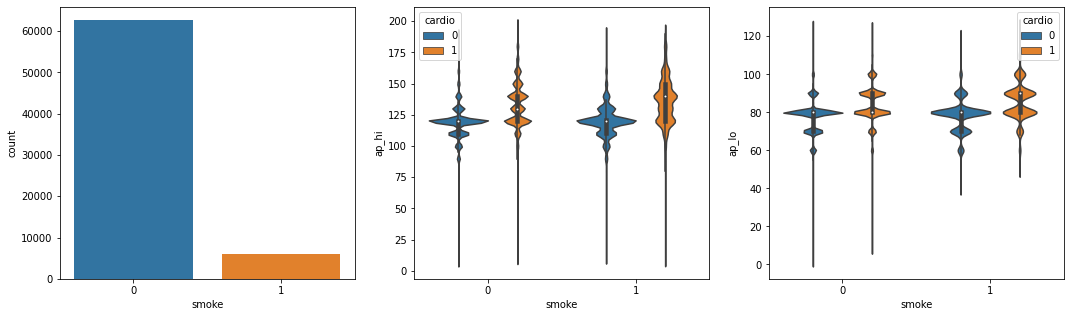

In [24]:
plt.figure(figsize=(18,5))
plt.subplot(1,3,1)
sns.countplot(x='smoke', data=df1);

plt.subplot(1,3,2)
sns.violinplot(x='smoke', y='ap_hi', hue='cardio', data=df1);

plt.subplot(1,3,3)
sns.violinplot(x='smoke', y='ap_lo', hue='cardio', data=df1);

### 3.1.9 Variável Alco - Álcool

A Grande maioria das pessoas da base de dados não bebem alcool.

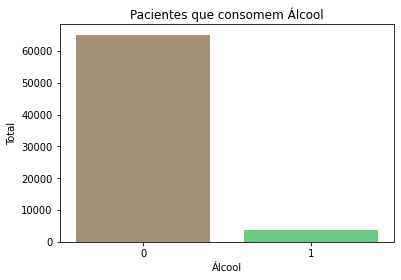

In [25]:
sns.countplot(x='alco', data=df1, palette='terrain_r');
plt.title('Pacientes que consomem Álcool')
plt.xlabel('Álcool')
plt.ylabel('Total');

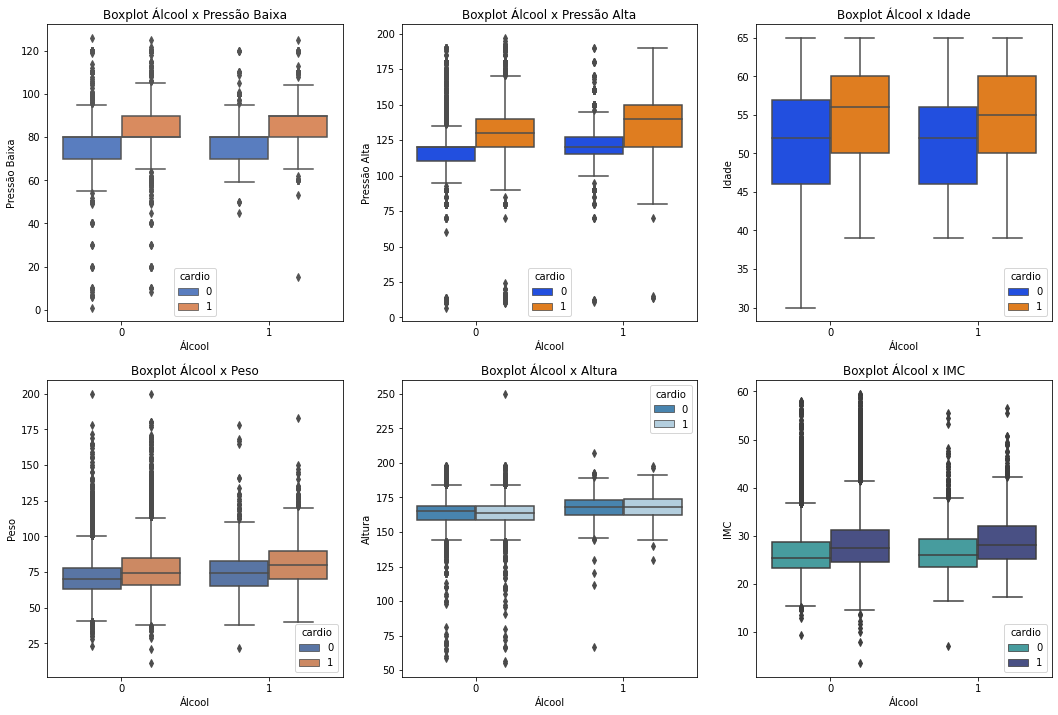

In [26]:
plt.figure(figsize=(18,12))
plt.subplot(2,3,1)
sns.boxplot(x='alco', y='ap_lo', hue='cardio', data=df1, palette='muted');
plt.title('Boxplot Álcool x Pressão Baixa')
plt.xlabel('Álcool')
plt.ylabel('Pressão Baixa');

plt.subplot(2,3,2)
sns.boxplot(x='alco', y='ap_hi', hue='cardio', data=df1, palette='bright');
plt.title('Boxplot Álcool x Pressão Alta')
plt.xlabel('Álcool')
plt.ylabel('Pressão Alta');

plt.subplot(2,3,3)
sns.boxplot(x='alco', y='age', hue='cardio', data=df1, palette='bright');
plt.title('Boxplot Álcool x Idade')
plt.xlabel('Álcool')
plt.ylabel('Idade');

plt.subplot(2,3,4)
sns.boxplot(x='alco', y='weight', hue='cardio', data=df1, palette='deep');
plt.title('Boxplot Álcool x Peso')
plt.xlabel('Álcool')
plt.ylabel('Peso');

plt.subplot(2,3,5)
sns.boxplot(x='alco', y='height', hue='cardio', data=df1, palette='Blues_r');
plt.title('Boxplot Álcool x Altura')
plt.xlabel('Álcool')
plt.ylabel('Altura');

plt.subplot(2,3,6)
aux = df1[(df['imc']<60)]
sns.boxplot(x='alco', y='imc', hue='cardio', data=aux, palette='mako_r');
plt.title('Boxplot Álcool x IMC')
plt.xlabel('Álcool')
plt.ylabel('IMC');

- Poucas pessoas da base de dados consomem alcool, então essa varíavel sozinha não parece ter efeito em doenças no coração.

- Quem tem doença no coração normalmente tem: Mais idade, uma maior pressão alta, uma maior pressão baixa e mais peso.

- A altura não parece influenciar em nada sozinha.

### 3.1.10 - Variável Active - Atividade Física

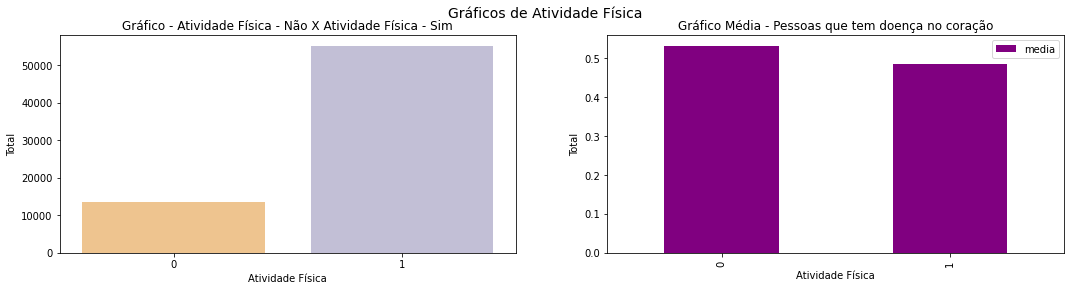

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))
sns.countplot(x='active', data=df1, ax=ax[0], palette="PuOr");
ax[0].set_title('Gráfico - Atividade Física - Não X Atividade Física - Sim')
ax[0].set_xlabel('Atividade Física')
ax[0].set_ylabel('Total')
fig.suptitle('Gráficos de Atividade Física', fontsize=14)

df2 = df1[['active', 'cardio']].groupby('active').count().reset_index()
hue0 = df1[(df1['active']==0) & (df1['cardio']==1)].shape[0]
hue1 = df1[(df1['active']==1) & (df1['cardio']==1)].shape[0]
hue = pd.DataFrame([hue0, hue1])
df3 = pd.concat([df2, hue], axis=1)
df3['media'] = df3[0]/df3['cardio']
df3 = df3[['active', 'media']]
df3.set_index('active',inplace=True)
df3.plot.bar(ax=ax[1], color='purple');
ax[1].set_title('Gráfico Média - Pessoas que tem doença no coração')
ax[1].set_xlabel('Atividade Física')
ax[1].set_ylabel('Total');

A Grande maioria das pessoas do dataset fazem atividade física, porém em média, quem tem doença no coração não faz atividade física. Isso por si só não explica muita coisa, pois quem tem doença no coração pode não fazer atividade por outros motivos como obesidade, idade, etc.

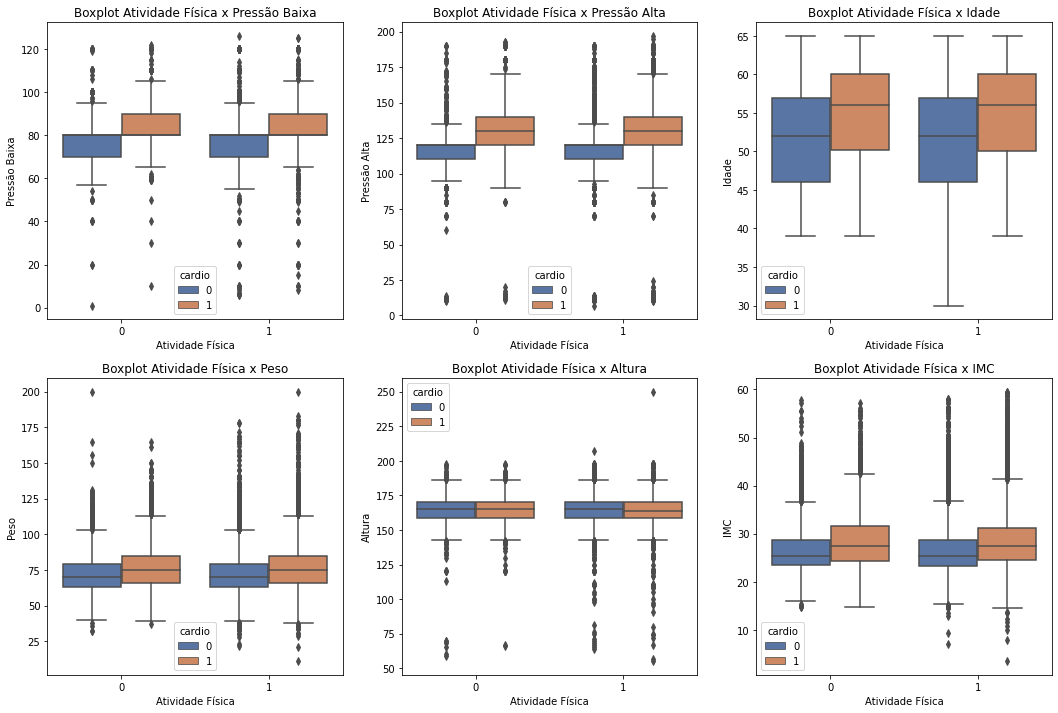

In [29]:
plt.figure(figsize=(18,12))
plt.subplot(2,3,1)
sns.boxplot(x='active', y='ap_lo', hue='cardio', data=df1, palette='deep');
plt.title('Boxplot Atividade Física x Pressão Baixa')
plt.xlabel('Atividade Física')
plt.ylabel('Pressão Baixa');

plt.subplot(2,3,2)
sns.boxplot(x='active', y='ap_hi', hue='cardio', data=df1, palette='deep');
plt.title('Boxplot Atividade Física x Pressão Alta')
plt.xlabel('Atividade Física')
plt.ylabel('Pressão Alta');

plt.subplot(2,3,3)
sns.boxplot(x='active', y='age', hue='cardio', data=df1, palette='deep');
plt.title('Boxplot Atividade Física x Idade')
plt.xlabel('Atividade Física')
plt.ylabel('Idade');

plt.subplot(2,3,4)
sns.boxplot(x='active', y='weight', hue='cardio', data=df1, palette='deep');
plt.title('Boxplot Atividade Física x Peso')
plt.xlabel('Atividade Física')
plt.ylabel('Peso');

plt.subplot(2,3,5)
sns.boxplot(x='active', y='height', hue='cardio', data=df1, palette='deep');
plt.title('Boxplot Atividade Física x Altura')
plt.xlabel('Atividade Física')
plt.ylabel('Altura');

plt.subplot(2,3,6)
aux = df1[(df['imc']<60)]
sns.boxplot(x='active', y='imc', hue='cardio', data=aux, palette='deep');
plt.title('Boxplot Atividade Física x IMC')
plt.xlabel('Atividade Física')
plt.ylabel('IMC');

### 3.1.11 - Variável Sum Risk Factors - Fatores de Risco Somados

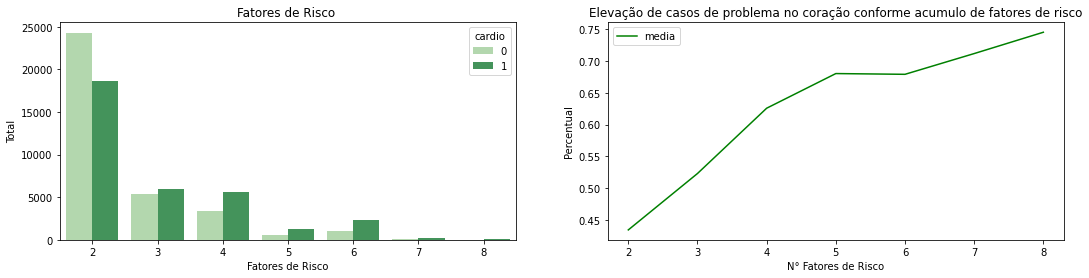

In [30]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))
sns.countplot(x='sum_risk_factors', hue='cardio', data=df1, palette='Greens', ax=ax[0]);
ax[0].set_title('Fatores de Risco ')
ax[0].set_xlabel('Fatores de Risco')
ax[0].set_ylabel('Total');

df2 = df1[['sum_risk_factors', 'cardio']].groupby('sum_risk_factors').count().reset_index()
hue2 = df1[(df1['sum_risk_factors']==2) & (df1['cardio']==1)].shape[0]
hue3 = df1[(df1['sum_risk_factors']==3) & (df1['cardio']==1)].shape[0]
hue4 = df1[(df1['sum_risk_factors']==4) & (df1['cardio']==1)].shape[0]
hue5 = df1[(df1['sum_risk_factors']==5) & (df1['cardio']==1)].shape[0]
hue6 = df1[(df1['sum_risk_factors']==6) & (df1['cardio']==1)].shape[0]
hue7 = df1[(df1['sum_risk_factors']==7) & (df1['cardio']==1)].shape[0]
hue8 = df1[(df1['sum_risk_factors']==8) & (df1['cardio']==1)].shape[0]
hue = pd.DataFrame([hue2, hue3, hue4, hue5, hue6, hue7, hue8])
df3 = pd.concat([df2, hue], axis=1)
df3['media'] = df3[0]/df3['cardio']
df3 = df3[['sum_risk_factors', 'media']]
df3.set_index('sum_risk_factors',inplace=True)
df3.plot(ax=ax[1], color='Green');
ax[1].set_title('Elevação de casos de problema no coração conforme acumulo de fatores de risco')
ax[1].set_xlabel('N° Fatores de Risco')
ax[1].set_ylabel('Percentual');

### 3.1.12 - Variável Activity Weight - Peso da atividade física em quem tem fatores de Risco

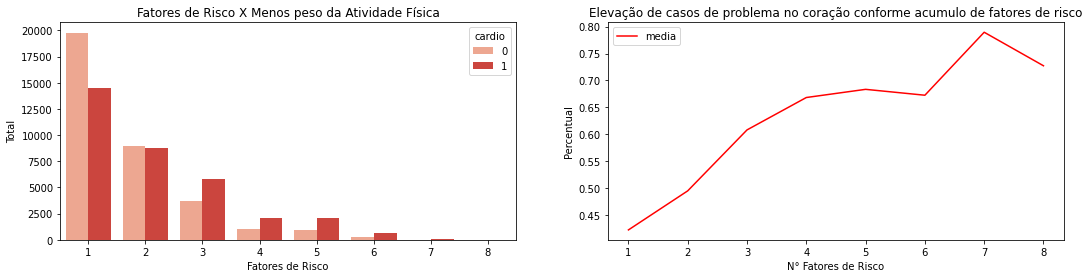

In [31]:
fig, ax = plt.subplots(1, 2, figsize=(18,4))
sns.countplot(x='activity_weight', hue='cardio', data=df1, ax=ax[0], palette= "Reds");
ax[0].set_title('Fatores de Risco X Menos peso da Atividade Física')
ax[0].set_xlabel('Fatores de Risco')
ax[0].set_ylabel('Total');

df2 = df1[['activity_weight', 'cardio']].groupby('activity_weight').count().reset_index()
hue1 = df1[(df1['activity_weight']==1) & (df1['cardio']==1)].shape[0]
hue2 = df1[(df1['activity_weight']==2) & (df1['cardio']==1)].shape[0]
hue3 = df1[(df1['activity_weight']==3) & (df1['cardio']==1)].shape[0]
hue4 = df1[(df1['activity_weight']==4) & (df1['cardio']==1)].shape[0]
hue5 = df1[(df1['activity_weight']==5) & (df1['cardio']==1)].shape[0]
hue6 = df1[(df1['activity_weight']==6) & (df1['cardio']==1)].shape[0]
hue7 = df1[(df1['activity_weight']==7) & (df1['cardio']==1)].shape[0]
hue8 = df1[(df1['activity_weight']==8) & (df1['cardio']==1)].shape[0]
hue = pd.DataFrame([hue1,hue2, hue3, hue4, hue5, hue6, hue7, hue8])
df3 = pd.concat([df2, hue], axis=1)
df3['media'] = df3[0]/df3['cardio']
df3 = df3[['activity_weight', 'media']]
df3.set_index('activity_weight',inplace=True)
df3.plot(ax=ax[1], color="red");
ax[1].set_title('Elevação de casos de problema no coração conforme acumulo de fatores de risco')
ax[1].set_xlabel('N° Fatores de Risco')
ax[1].set_ylabel('Percentual');

### 3.1.13 - IMC

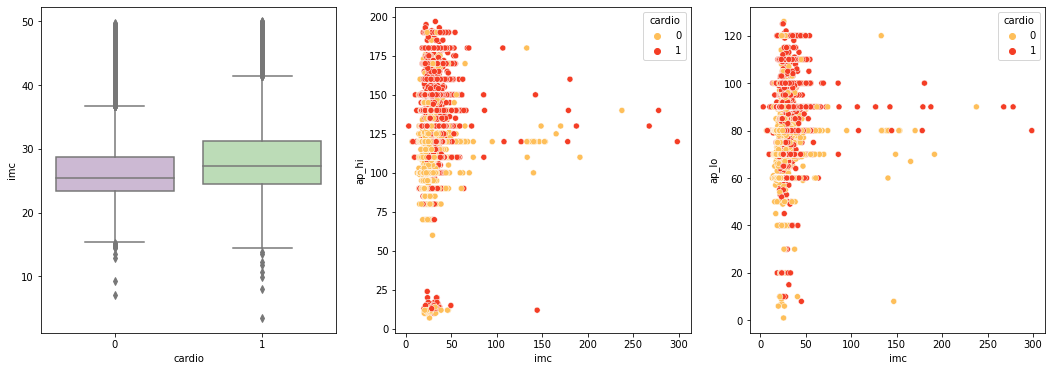

In [32]:
plt.figure(figsize=(18,6))
plt.subplot(1,3,1)
aux = df1[(df1['imc']<50)]
sns.boxplot(x='cardio', y='imc', data=aux, palette="PRGn")

plt.subplot(1,3,2)
sns.scatterplot(x='imc', y='ap_hi', hue='cardio', data=df1,palette="YlOrRd" )

plt.subplot(1,3,3)
sns.scatterplot(x='imc', y='ap_lo', hue='cardio', data=df1, palette="YlOrRd");

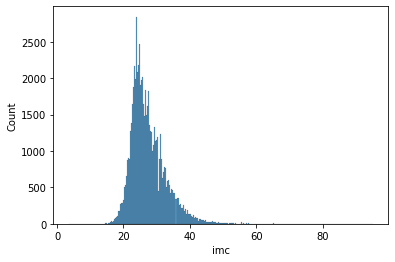

In [33]:
aux = df1[(df1['imc']<100)]
sns.histplot(x=aux['imc']);

### 3.1.14 - Nível de Obesidade

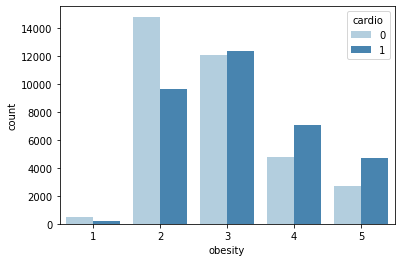

In [34]:
sns.countplot(x='obesity', hue='cardio', data=df1, palette='Blues');

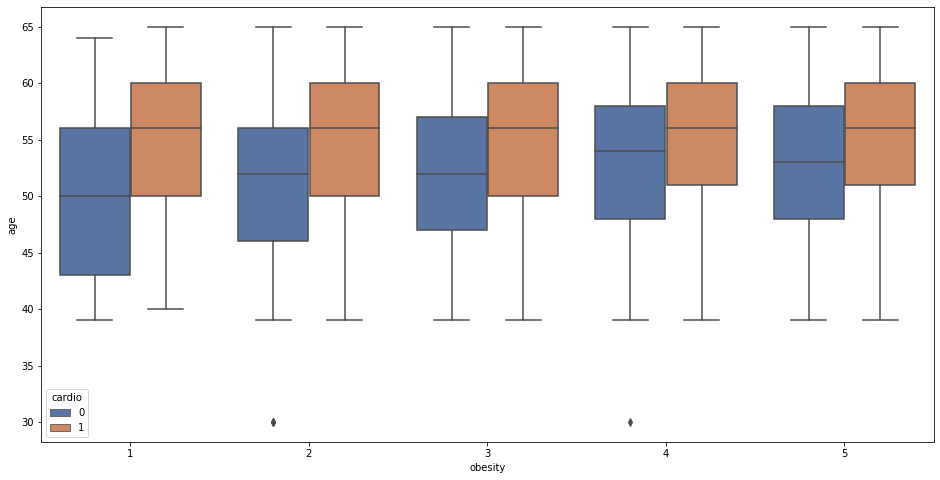

In [35]:
plt.figure(figsize=(16,8))
sns.boxplot(x='obesity', y='age', hue='cardio',data=df1, palette='deep');

In [36]:
# Independente do nível de obesidade, quem teve mais problemas cardíacos são sempre pessoas de mais idade.

### 3.2 - Distribuição das variáveis

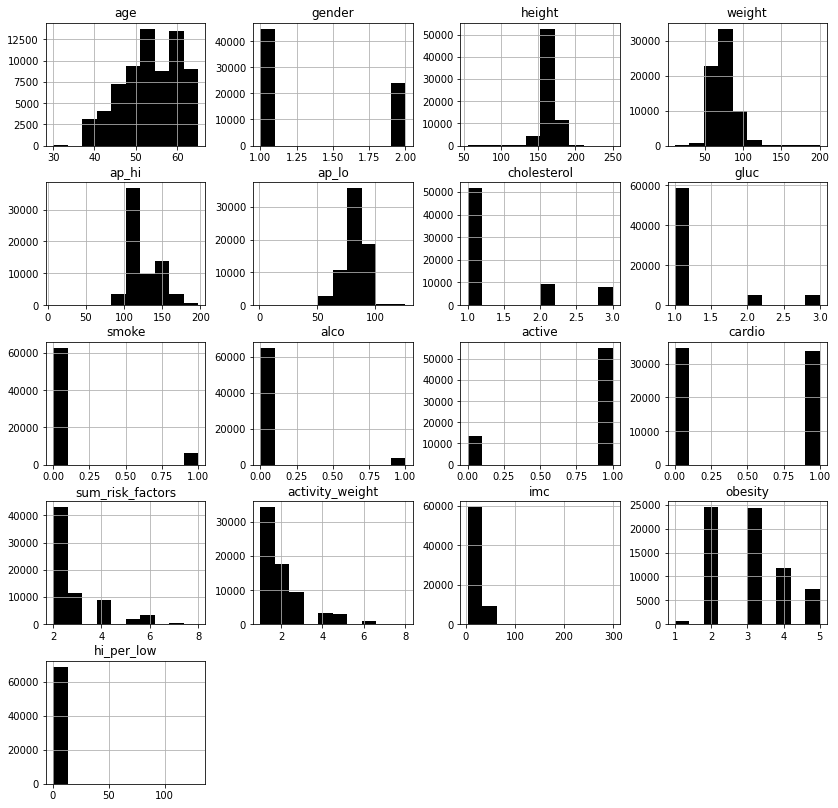

In [37]:
df2 = df1.drop(['id'], axis=1)
fig = plt.figure(figsize=(14,14))
ax = fig.gca()
df2.hist(ax=ax, color='black');

## 3.2 Análise Bivariada

**H1 -** Pessoas com mais de 60 anos tem duas vezes mais chances de ter problema no coração do que uma pessoa com menos de 60 anos.

**Falso** - Pessoas com mais de 60 anos tem em média sete vezes mais chances de ter problemas no coração.

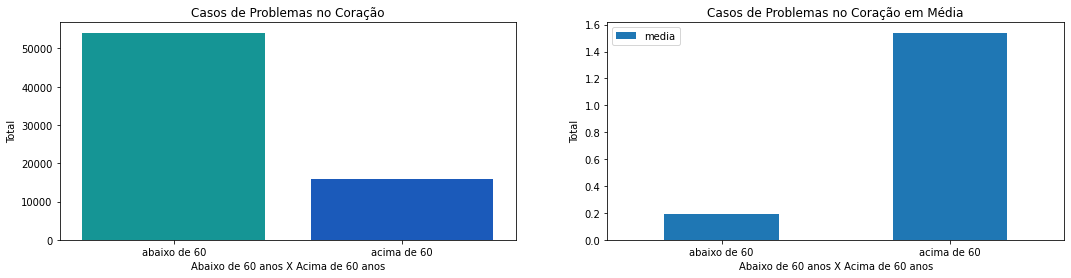

In [38]:
df['faixa_etaria'] = df['age'].apply(lambda x: 'acima de 60' if x >= 60 else 'abaixo de 60')
aux = df[['faixa_etaria', 'cardio']].groupby('faixa_etaria').count().reset_index()

hue1 = df[(df['faixa_etaria']=='acima de 60') & (df['cardio']==1)].shape[0]
hue2 = df[(df['faixa_etaria']=='abaixo de 60') & (df['cardio']==1)].shape[0]

hue = pd.DataFrame([hue1,hue2])
aux = pd.concat([aux, hue], axis=1)

aux['media'] = aux[0]/aux['cardio']
aux = aux[['faixa_etaria', 'media']]
aux.set_index('faixa_etaria',inplace=True)
fig, ax = plt.subplots(1, 2, figsize=(18,4))
aux.plot.bar(ax=ax[1]);
ax[1].set_title('Casos de Problemas no Coração em Média')
ax[1].set_xlabel('Abaixo de 60 anos X Acima de 60 anos')
plt.xticks(rotation = 0)
ax[1].set_ylabel('Total');

sns.countplot(x='faixa_etaria', data=df, palette='winter_r', ax=ax[0]);
ax[0].set_title('Casos de Problemas no Coração')
ax[0].set_xlabel('Abaixo de 60 anos X Acima de 60 anos')
ax[0].set_ylabel('Total');

**H2 -** Em média, um gênero tem mais chances de ter problema no coração do que o outro.

**Falso** - Homens e mulheres tem a mesma chance de ter problemas no coração.

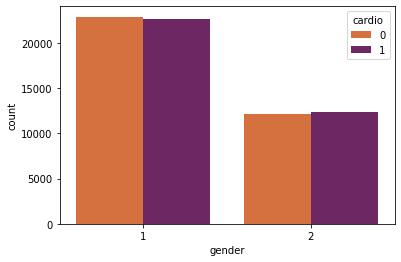

In [39]:
sns.countplot(x='gender', hue='cardio', data=df, palette='inferno_r');

**H3 -** Pressão alta acima de 140 aumenta duas vezes o risco de ter problema no coração.

**Falso** - Pressão alta acima de 140 aumenta três vezes o risco de ter problemas no coração.

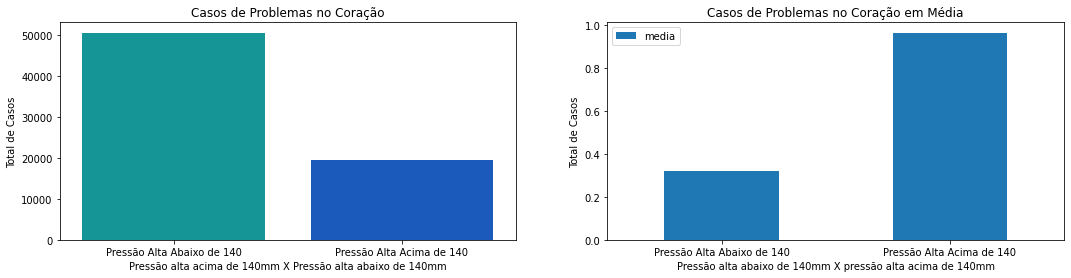

In [40]:
df['faixa_ap_hi'] = df['ap_hi'].apply(lambda x: 'Pressão Alta Acima de 140' if x >= 140 else 'Pressão Alta Abaixo de 140')
aux = df[['faixa_ap_hi', 'cardio']].groupby('faixa_ap_hi').count().reset_index()

hue1 = df[(df['faixa_ap_hi']=='Pressão Alta Acima de 140') & (df['cardio']==1)].shape[0]
hue2 = df[(df['faixa_ap_hi']=='Pressão Alta Abaixo de 140') & (df['cardio']==1)].shape[0]

hue = pd.DataFrame([hue1,hue2])
aux = pd.concat([aux, hue], axis=1)

aux['media'] = aux[0]/aux['cardio']
aux = aux[['faixa_ap_hi', 'media']]
aux.set_index('faixa_ap_hi',inplace=True)
fig, ax = plt.subplots(1, 2, figsize=(18,4))
aux.plot.bar(ax=ax[1]);
ax[1].set_title('Casos de Problemas no Coração em Média')
ax[1].set_xlabel('Pressão alta abaixo de 140mm X pressão alta acima de 140mm')
plt.xticks(rotation = 0)
ax[1].set_ylabel('Total de Casos');

sns.countplot(x='faixa_ap_hi', data=df, palette='winter_r', ax=ax[0]);
ax[0].set_title('Casos de Problemas no Coração')
ax[0].set_xlabel('Pressão alta acima de 140mm X Pressão alta abaixo de 140mm')
ax[0].set_ylabel('Total de Casos');

**H4 -** Pressão baixa acima de 80 aumenta duas vezes o risco de ter problema no coração.

**Falso** - Em média, a maioria dos casos de problema no coração é em quem tem uma pressão baixa abaixo de 80mm.

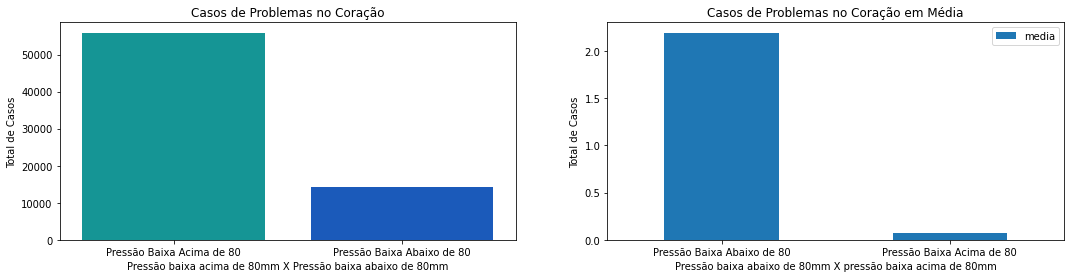

In [41]:
df['faixa_ap_lo'] = df['ap_lo'].apply(lambda x: 'Pressão Baixa Acima de 80' if x >= 80 else 'Pressão Baixa Abaixo de 80')
aux = df[['faixa_ap_lo', 'cardio']].groupby('faixa_ap_lo').count().reset_index()

hue1 = df[(df['faixa_ap_lo']=='Pressão Baixa Acima de 80') & (df['cardio']==1)].shape[0]
hue2 = df[(df['faixa_ap_lo']=='Pressão Baixa Abaixo de 80') & (df['cardio']==1)].shape[0]

hue = pd.DataFrame([hue1,hue2])
aux = pd.concat([aux, hue], axis=1)

aux['media'] = aux[0]/aux['cardio']
aux = aux[['faixa_ap_lo', 'media']]
aux.set_index('faixa_ap_lo',inplace=True)
fig, ax = plt.subplots(1, 2, figsize=(18,4))
aux.plot.bar(ax=ax[1]);
ax[1].set_title('Casos de Problemas no Coração em Média')
ax[1].set_xlabel('Pressão baixa abaixo de 80mm X pressão baixa acima de 80mm')
plt.xticks(rotation = 0)
ax[1].set_ylabel('Total de Casos');

sns.countplot(x='faixa_ap_lo', data=df, palette='winter_r', ax=ax[0]);
ax[0].set_title('Casos de Problemas no Coração')
ax[0].set_xlabel('Pressão baixa acima de 80mm X Pressão baixa abaixo de 80mm')
ax[0].set_ylabel('Total de Casos');

## 3.3 - Análise Multivariada

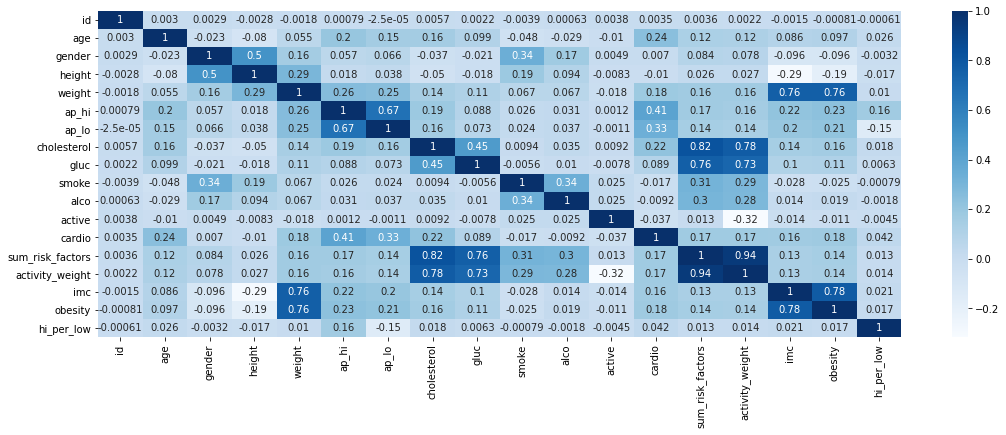

In [42]:
corr = df1.corr()
plt.figure(figsize=(18,6))
sns.heatmap(corr, annot=True, cmap="Blues");

## 4.0 - Preparação dos Dados